In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm
import seaborn as sns
import nltk
import json

%matplotlib inline

In [2]:
from pymystem3 import Mystem
from string import punctuation

In [3]:
def read_queries_with_lemmatization(path):
    f = open(path)
    queries = []
    tags = []
    mystem = Mystem()
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        tmp_ = []
        text = tokenizer.tokenize(line.lower())
        text_tagged = nltk.pos_tag(text, lang='rus')
        
        for i, q in enumerate(text):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                q_ = mystem.lemmatize(q)
                tmp.append("".join(q_).split()[0])
                tmp_.append(text_tagged[i][1])
        queries.append(tmp)
        tags.append(tmp_)
    f.close()
    return (queries, tags)

In [4]:
path = 'data/requests.uniq.train'
train_lem = read_queries_with_lemmatization(path)
path = 'data/requests.uniq.test'
test_lem = read_queries_with_lemmatization(path)
train_lem[0][:5], train_lem[1][:5], test_lem[0][:5], test_lem[1][:5], len(train_lem[0]), len(test_lem[0])

([['сибирский', 'сеть', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карта', 'россия'],
  ['ноофен', 'для', 'какой', 'болезнь'],
  ['маус', 'хаус', 'спб']],
 [['A=pl', 'S', 'A=m', 'S', 'S'],
  ['NUM=ciph', 'V', 'S', 'NUM=ciph'],
  ['S', 'S', 'PR', 'S', 'S'],
  ['V', 'PR', 'A-PRO=pl', 'A=f'],
  ['NONLEX', 'NONLEX', 'NONLEX']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикий', 'вишня'],
  ['тася', 'кривун', 'танец', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 [['V', 'PR', 'S', 'S'],
  ['S', 'A=f', 'S'],
  ['S', 'S', 'S', 'PR', 'S'],
  ['V', 'S'],
  ['NONLEX', 'NONLEX', 'NONLEX']],
 51353,
 21174)

In [5]:
count_words = Counter()

for d in [train_lem[0]]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.12185658, 0.16966756, 0.20326518, 0.23018925, 0.2515358 ,
        0.27062838, 0.28792218, 0.30358516, 0.31885922, 0.32964299]))

In [6]:
emb_2 = KeyedVectors.load_word2vec_format("ft_native_300_ru_wiki_lenta_lower_case.vec")

In [7]:
tmp = np.unique(np.hstack(train_lem[1]))
tmp1 = np.unique(np.hstack(test_lem[1]))
tmp = np.hstack([tmp, tmp1])
tmp = np.unique(tmp)
tmp, len(tmp)

(array(['A', 'A-PRO', 'A-PRO=f', 'A-PRO=m', 'A-PRO=n', 'A-PRO=pl',
        'A-PRO=sg', 'A=brev', 'A=comp', 'A=comp2', 'A=f', 'A=m', 'A=n',
        'A=pl', 'A=sg', 'ADV', 'ADV-PRO', 'ADV-PRO=abbr', 'ADV-PRO=comp',
        'ADV-PRO=distort', 'ADV=abbr', 'ADV=comp', 'ADV=comp2',
        'ANUM=ciph', 'ANUM=f', 'ANUM=m', 'ANUM=n', 'ANUM=pl', 'ANUM=sg',
        'CONJ', 'INIT=abbr', 'INTJ', 'INTJ=distort', 'NONLEX',
        'NONLEX=abbr', 'NUM', 'NUM=acc', 'NUM=ciph', 'NUM=comp', 'NUM=dat',
        'NUM=f', 'NUM=gen', 'NUM=ins', 'NUM=loc', 'NUM=m', 'NUM=n',
        'NUM=nom', 'PARENTH', 'PART', 'PR', 'PRAEDIC', 'PRAEDIC-PRO',
        'PRAEDIC=comp', 'S', 'S-PRO', 'S-PRO=acc', 'S-PRO=dat',
        'S-PRO=gen', 'S-PRO=ins', 'S-PRO=loc', 'S-PRO=n=sg', 'S-PRO=pl',
        'S=m', 'V'], dtype='<U32'), 64)

In [8]:
tags = tmp
tags_to_ind = {}
ind = 0
for t in tags:
    tags_to_ind[t] = ind
    ind += 1

## Сетки

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
def calculate_n_tokens(emb):
    n_tokens = 0
    for word in count_words.keys():
        if word in emb.vocab and count_words[word] >= 3:
            n_tokens += 1
    return n_tokens + 1

In [11]:
def transform_to_features(emb, emb_size, ind_to_word, batch_x, batch_x_tags):
    to_emb = np.zeros((len(batch_x), len(batch_x[0])+1, emb_size + len(tags)))
    for i in range(len(batch_x)):
        to_emb[i][0] = np.ones(emb_size + len(tags))
        for j in range(len(batch_x[i])):
            if batch_x[i][j] != pad_id:
                to_emb[i][j+1][:emb_size] = emb[ind_to_word[batch_x[i][j]]]
                if batch_x_tags[i][j] >= 0:
                    to_emb[i][j+1][emb_size + batch_x_tags[i][j]] = 1
    return to_emb

In [12]:
class NetWithAttention(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256, hid_size=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.linear_lstm = nn.Linear(lstm_units, hid_size)
        self.linear_out_lstm = nn.Linear(lstm_units, hid_size)
        self.final_linear = nn.Linear(hid_size, 1)
        self.logits = nn.Linear(hid_size, n_tokens)
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        #lstm_out = lstm_out[0][1:]
        
        
        lstm_out_linear = self.linear_out_lstm(lstm_out[0])
        lstm_linear = self.linear_lstm(lstm_out[0])
        pre_logits = torch.zeros_like(lstm_out[0])
        pre_logits[:, 0, :] = lstm_out[0][:, 0, :]
        pre_logits[:, 1, :] = lstm_out[0][:, 1, :]
        
        mask = np.array([batch_x == pad_id], dtype=int)[0]
        mask = torch.tensor(mask, dtype=torch.float32)
        #print(mask.shape)
        
        for i in range(2, pre_logits.shape[1]):
            to_add = lstm_out_linear[:, i, :]
            basic = lstm_linear[:, 1:i+1, :]
            to_add = to_add.reshape(pre_logits.shape[0], 1, pre_logits.shape[2])
            tmp = basic + to_add
            tmp = torch.tanh(tmp)
            tmp = self.final_linear(tmp)
            tmp = tmp.reshape(tmp.shape[0], tmp.shape[1])
            tmp = F.softmax(tmp, dim=1)
            #print(tmp.shape)
            #print(mask.shape)
            mask = np.array([batch_x == pad_id], dtype=int)[0][:, :i]
            mask[:, -1] = np.ones(mask.shape[0])
            mask = torch.tensor(mask, dtype=torch.float32)
            
            tmp = tmp * mask
            tmp = tmp / torch.sum(tmp, dim=1).reshape(-1, 1)
            tmp = tmp.reshape(tmp.shape[0], tmp.shape[1], 1)
            pre_logits[:, i, :] = torch.sum(tmp * lstm_out[0][:, 1:i+1, :], dim=1)
        
        logits = self.logits(pre_logits)
        return logits

In [13]:
pad = '#PAD#'
pad_id = 0

def construct_vocab(emb, count_words):
    word_to_ind = dict()
    word_to_ind['#PAD#'] = 0
    ind_to_word = ['#PAD#', ]
    
    count = 1
    for word in count_words.keys():
        if count_words[word] >= 3 and word in emb.vocab:
            ind_to_word.append(word)
            word_to_ind[word] = count
            count += 1
    return ind_to_word, word_to_ind


def as_matrix(sequences, tags, word_to_ind, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((2, len(sequences), max_len), dtype=int)
    for i, seq in enumerate(sequences):
        for j, word in enumerate(seq[:max_len]):
            if word in word_to_ind.keys():
                matrix[0][i][j] = word_to_ind[word]
                matrix[1][i][j] = tags_to_ind[tags[i][j]]
            else:
                matrix[0][i][j] = pad_id
                matrix[1][i][j] = -1
        for j in range(max_len, len(seq)):
            matrix[0][i][j] = pad_id
            matrix[1][i][j] = -1
    
    return matrix

In [14]:
ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = NetWithAttention(emb_2, ind_to_word)
network.load_state_dict(torch.load('additive_attention.pwf'))

In [15]:
from tqdm import tqdm

def get_batch(data, left, right, batch_size, word_to_ind, max_len=None):
    slice_x = np.arange(left, right, 1)
    batch_x = []
    batch_tag = []
    for x in slice_x:
        batch_x.append(data[0][x])
        batch_tag.append(data[1][x])
    return as_matrix(batch_x, batch_tag, word_to_ind, max_len)

In [17]:
from random import choice

def generate_batch(train, batch_size, word_to_ind, max_len=None):
    random_x = np.random.randint(0, len(train[0]), size=batch_size)
    batch_x = []
    batch_tags = []
    for x in random_x:
        batch_x.append(train[0][x])
        batch_tags.append(train[1][x])
    return as_matrix(batch_x, batch_tags, word_to_ind, max_len)

In [18]:
class NetWithAttentionCosine(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256, hid_size=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits = nn.Linear(hid_size, n_tokens)
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)        
        
        pre_logits = torch.zeros_like(lstm_out[0])
        pre_logits[:, 0, :] = lstm_out[0][:, 0, :]
        pre_logits[:, 1, :] = lstm_out[0][:, 1, :]
        
        for i in range(2, pre_logits.shape[1]):
            current = lstm_out[0][:, i, :]
            previous = lstm_out[0][:, 1:i+1, :]
            current = current.reshape(pre_logits.shape[0], 1, pre_logits.shape[2])
            cosine = torch.sum(previous * current, dim=-1) / torch.sum(previous * previous, dim=-1)
            cosine /= torch.sum(current * current)
            cosine = F.softmax(cosine, dim=1)
            
            mask = np.array([batch_x == pad_id], dtype=int)[0][:, :i]
            mask[:, -1] = np.ones(mask.shape[0])
            mask = torch.tensor(mask, dtype=torch.float32)
            
            tmp = cosine * mask
            tmp = tmp / torch.sum(tmp, dim=1).reshape(-1, 1)
            tmp = tmp.reshape(tmp.shape[0], tmp.shape[1], 1)
            pre_logits[:, i, :] = torch.sum(tmp * lstm_out[0][:, 1:i+1, :], dim=1)
        
        logits = self.logits(pre_logits)
        return logits

network_1 = NetWithAttentionCosine(emb_2, ind_to_word)
network_1.load_state_dict(torch.load('cosine_attention.pwf'))

In [19]:
class NetWithAttentionDotProduct(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256, hid_size=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits = nn.Linear(hid_size, n_tokens)
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)        
        
        pre_logits = torch.zeros_like(lstm_out[0])
        pre_logits[:, 0, :] = lstm_out[0][:, 0, :]
        pre_logits[:, 1, :] = lstm_out[0][:, 1, :]
        
        for i in range(2, pre_logits.shape[1]):
            current = lstm_out[0][:, i, :]
            previous = lstm_out[0][:, 1:i+1, :]
            current = current.reshape(pre_logits.shape[0], 1, pre_logits.shape[2])
            dot_product = torch.sum(previous * current, dim=-1)
            dot_product = F.softmax(dot_product, dim=1)
            
            mask = np.array([batch_x == pad_id], dtype=int)[0][:, :i]
            mask[:, -1] = np.ones(mask.shape[0])
            mask = torch.tensor(mask, dtype=torch.float32)
            
            tmp = dot_product * mask
            tmp = tmp / torch.sum(tmp, dim=1).reshape(-1, 1)
            tmp = tmp.reshape(tmp.shape[0], tmp.shape[1], 1)
            pre_logits[:, i, :] = torch.sum(tmp * lstm_out[0][:, 1:i+1, :], dim=1)
        
        logits = self.logits(pre_logits)
        return logits
    
network_2 = NetWithAttentionDotProduct(emb_2, ind_to_word)
network_2.load_state_dict(torch.load('dotproduct_attention.pwf'))

In [20]:
class NetWithAttentionLocbased(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256, hid_size=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits = nn.Linear(hid_size, n_tokens)
        self.inner = nn.Linear(lstm_units, 1)
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)        
        
        pre_logits = torch.zeros_like(lstm_out[0])
        pre_logits[:, 0, :] = lstm_out[0][:, 0, :]
        pre_logits[:, 1, :] = lstm_out[0][:, 1, :]
        
        for i in range(2, pre_logits.shape[1]):
            current = lstm_out[0][:, i, :]
            current = self.inner(current)
            current = F.softmax(current, dim=1)
            
            mask = np.array([batch_x == pad_id], dtype=int)[0][:, :i]
            mask[:, -1] = np.ones(mask.shape[0])
            mask = torch.tensor(mask, dtype=torch.float32)
            
            tmp = current * mask
            tmp = tmp / torch.sum(tmp, dim=1).reshape(-1, 1)
            tmp = tmp.reshape(tmp.shape[0], tmp.shape[1], 1)
            pre_logits[:, i, :] = torch.sum(tmp * lstm_out[0][:, 1:i+1, :], dim=1)
        
        logits = self.logits(pre_logits)
        return logits
    
network_3 = NetWithAttentionLocbased(emb_2, ind_to_word)
network_3.load_state_dict(torch.load('locationbased_attention.pwf'))

In [21]:
class Net(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size + len(tags), lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens) 
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x, batch_x_tags):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x, batch_x_tags)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        logits = self.logits(lstm_out[0])
        
        return logits
    
network_4 = Net(emb_2, ind_to_word)
network_4.load_state_dict(torch.load('add_pos_tagging_as_feature.pwf'))

In [23]:
n_tokens = calculate_n_tokens(emb_2)
n_tokens

9781

In [71]:
class FinalNet(nn.Module):
    def __init__(self, inner, hid_size=256):
        super(self.__class__, self).__init__()
        self.linear = nn.Linear(inner, 1)
        
    def forward(self, batch_x):
        logits = self.linear(batch_x)
        return logits
    

def compute_features(network, batch):
    batch_x = batch[0]
    batch_tag = batch[1]
    
    batch_x = np.array(batch_x)
    batch_tag = np.array(batch_tag)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    batch_tag_inp = batch_tag[:, :-1]
    
    logits_for_next = network.forward(batch_x_inp, batch_tag_inp)
    logits_for_next = logits_for_next[:, 1:].detach().numpy()
    
    count = np.sum([batch_x_next != 0])
    raveled = np.zeros((count, n_tokens))
    answers = np.zeros(count)
    count = 0
    bounds = []
    
    for j in range(batch_x_next.shape[1]):
        for i in range(batch_x_next.shape[0]):
            if batch_x_next[i][j] != 0:
                raveled[count] = logits_for_next[i][j]
                answers[count] = batch_x_next[i][j]
                count += 1
        bounds.append(count)
    
    return raveled, answers, bounds

def compute_loss(network, batch, real_answers):
    """
    use scalar crossentropy loss (neg llh) loss 
    """
    batch = torch.tensor(batch, dtype=torch.float32)
    logits = network.forward(batch)
    logits = logits.view(-1, logits.shape[1])
    
    answers = torch.argmax(logits, dim=-1).numpy()
    logits = logits.contiguous()
    
    accr = np.array([answers == real_answers]) * np.array([answers != pad_id])
    accr = accr.sum()
    to_div = np.sum(np.array([real_answers != pad_id]))
    
    batch_x_next = torch.tensor(real_answers, dtype=torch.int64)
    loss = F.cross_entropy(logits, batch_x_next, ignore_index=pad_id, reduction='mean')
    
    return loss, accr, to_div

In [72]:
batch_size = 64 
n_epochs = 1 
n_batches_per_epoch = 400  
n_validation_batches = 160

In [77]:
from torch.optim import Adam
from tqdm import tqdm_notebook

nets = [network, network_1, network_2, network_3, network_4]

final = FinalNet(5)
opt = Adam(final.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    to_div = 0
    final.train(True)
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        batch = generate_batch(train_lem, batch_size, word_to_ind)
        features, answers, bounds = compute_features(nets[0], batch)
        for i in range(1, len(nets)):
            feat, ans, b = compute_features(nets[i], batch)
            features = np.dstack([features, feat])
        
        loss_t, accr_t, to_div_t = compute_loss(final, features, answers)
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        to_div += to_div_t
        
    train_loss_ /= n_batches_per_epoch
    #train_accr_ /= n_batches_per_epoch
    train_accr_ /= to_div
    
    val_loss_=0
    val_accr_=0
    to_div = 0
    final.train(False)
    for _ in range(n_validation_batches):
        batch = generate_batch(test_lem, batch_size, word_to_ind)
        features, answers, bounds = compute_features(nets[0], batch)
        for i in range(1, len(nets)):
            feat, ans, b = compute_features(nets[i], batch)
            features = np.dstack([features, feat])
        
        loss_t, accr_t, to_div_t = compute_loss(final, features, answers)
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
        to_div += to_div_t
        
    val_loss_ /= n_validation_batches
    #val_accr_ /= n_validation_batches
    val_accr_ /= to_div
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")


Epoch: 0, train loss: 4.858066913485527, val loss: 6.149513477087021

Epoch: 0, train accr: 0.2968316858460332, val accr: 0.1710985101961751
Finished!


In [78]:
torch.save(final.state_dict(), 'final_network.pwf')

In [110]:
def compute_accr(network, batch, real_answers, bounds):
    batch = torch.tensor(batch, dtype=torch.float32)
    logits = network.forward(batch)
    logits = logits.view(-1, logits.shape[1])
    
    answers = torch.argmax(logits, dim=-1).numpy()
    
    accr = np.array([answers == real_answers]) * np.array([answers != pad_id])
    accr = np.cumsum(accr)
    to_div = np.cumsum(np.array([real_answers != pad_id]))
    accuracy = np.zeros_like(bounds)
    to_divide = np.zeros_like(bounds)
    
    accuracy[0] = accr[bounds[0]-1]
    to_divide[0] = to_div[bounds[0]-1]
    for i in range(1, len(bounds)):
        accuracy[i] = accr[bounds[i]-1] - accr[bounds[i-1]-1]
        to_divide[i] = to_div[bounds[i]-1] - to_div[bounds[i-1]-1]
    
    return accuracy, to_divide


def try_lengthes(data):
    accr = np.zeros(np.max(list(map(len, data[0]))))
    to_div = np.zeros(np.max(list(map(len, data[0]))))
    
    for _ in tqdm_notebook(range(0, len(data[0])-batch_size, batch_size)):
        batch = get_batch(data, _, _+batch_size, batch_size, word_to_ind)
        features, answers, bounds = compute_features(nets[0], batch)
        for i in range(1, len(nets)):
            feat, ans, b = compute_features(nets[i], batch)
            features = np.dstack([features, feat])
        
        accr_t, div_t = compute_accr(final, features, answers, bounds)
        accr[:len(accr_t)] += accr_t
        to_div[:len(div_t)] += div_t
    eps = 1
    return accr / (to_div + eps), accr.sum() / to_div.sum()

In [111]:
on_test, all_accr = try_lengthes(test_lem)
on_test[:10], all_accr

(array([0.14423841, 0.15532299, 0.18745746, 0.20316119, 0.20641078,
        0.20500835, 0.21413276, 0.19251825, 0.17488076, 0.10662824]),
 0.17268032422449467)

In [ ]:
additive = [0.14205298, 0.14598705, 0.17501215, 0.18585638, 0.19293589, \
            0.19933222, 0.19914347, 0.19434307, 0.14467409, 0.10951009]

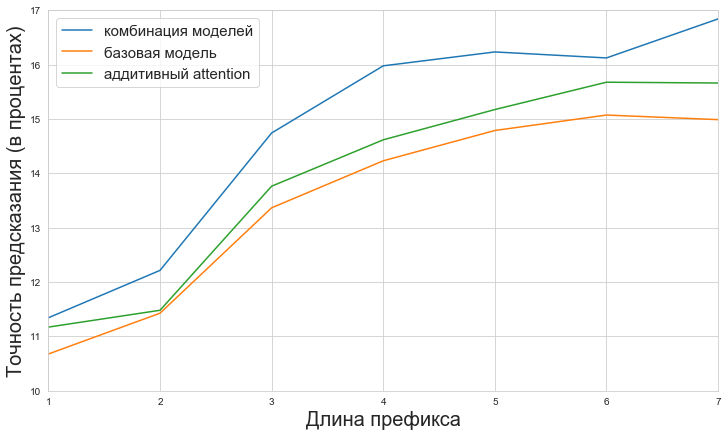

In [121]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 7) + 1
bound = len(grid)

additive = [0.14205298, 0.14598705, 0.17501215, 0.18585638, 0.19293589, \
            0.19933222, 0.19914347, 0.19434307, 0.14467409, 0.10951009]

path = 'emb_2_lemmatization.txt'
plt.plot(grid, 100*np.array(on_test[:bound], dtype=float) * (1-test_pad[path]), 
         label="комбинация моделей")
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="базовая модель")
plt.plot(grid, 100*np.array(additive[:bound], dtype=float) * (1-test_pad[path]), 
         label="аддитивный attention")


#plt.fill_between(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), alpha=0.2)

plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 7])
plt.ylim([10, 17])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("final.png")

Посмотрим как результаты соотносятся с теоретическими оценками

In [125]:
def bigramAnvanced(train, test):
    cnt = dict()
    for line in tqdm_notebook(train):
        prefix = ""
        for word in line:
            if prefix not in cnt and word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix = word
            else:
                prefix = "#PAD#"
    
    max_len = np.max(list(map(len, test)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(test):
        prefix = ''
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1   
            if word in count_words.keys() and count_words[word] >= 3:
                prefix = word 
            else:
                prefix = "#PAD#"
    return accrs[:, 0] / accrs[:, 1]

In [126]:
def calculateUpperBoundWithPadding(data, bound=3):
    cnt = dict()
    
    for line in tqdm_notebook(data):
        prefix = "#_#"
        for word in line:
            if prefix not in cnt.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix += word + "#_#"
            else:
                prefix += "#PAD#" + "#_#" 
    
    max_len = np.max(list(map(len, data)))
    accrs = np.zeros((max_len, 2))
    
    for line in tqdm_notebook(data):
        prefix = '#_#'
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = cnt[prefix].most_common(1)[0][0]
                if pred == word:
                    accrs[i, 0] += 1
            accrs[i, 1] += 1   
            if count_words[word] >= 3:
                prefix += word + "#_#"
            else:
                prefix += "#PAD#" + "#_#" 
    return accrs[:, 0] / accrs[:, 1]

In [129]:
tmp_pad = calculateUpperBoundWithPadding(test_lem[0])
tmp_pad[:10] * 100

array([ 2.91422634, 28.00486865, 58.11986614, 77.45985163, 83.79069767,
       86.13756614, 86.2474878 , 87.56428237, 87.61980831, 85.15519568])

In [132]:
bigram_adv = bigramAnvanced(train_lem[0], test_lem[0])
bigram_adv[:10]

array([0.02914226, 0.10913886, 0.10295102, 0.12439879, 0.13151163,
       0.12804233, 0.14097043, 0.14259   , 0.12779553, 0.11875843])

Как меняется качество биграммной модели при переходе к метрике top-n

In [197]:
def bigramAnvancedWithTop(train, test, n=10):
    cnt = dict()
    for line in tqdm_notebook(train):
        prefix = ""
        for word in line:
            if prefix not in cnt and word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix] = Counter()
            if word in count_words.keys() and count_words[word] >= 3:
                cnt[prefix][word] += 1
                prefix = word
            else:
                prefix = "#PAD#"
    
    max_len = np.max(list(map(len, test)))
    accrs = np.zeros((max_len, n))
    to_div = np.zeros((max_len, 1))
    
    for line in tqdm_notebook(test):
        prefix = ''
        for i, word in enumerate(line):
            if prefix in cnt:
                pred = np.array([x[0] for x in cnt[prefix].most_common(n)])
                word_ = np.array([word])
                tmp = np.cumsum(pred == word_)
                tmp_ = np.zeros(n)
                tmp_[:len(tmp)] += tmp
                tmp_[len(tmp):] += tmp[-1]
                accrs[i] += tmp_
            to_div[i] += 1   
            if word in count_words.keys() and count_words[word] >= 3:
                prefix = word 
            else:
                prefix = "#PAD#"
    return accrs / to_div

In [198]:
bigram_adv_top = bigramAnvancedWithTop(train_lem[0], test_lem[0], n=10)

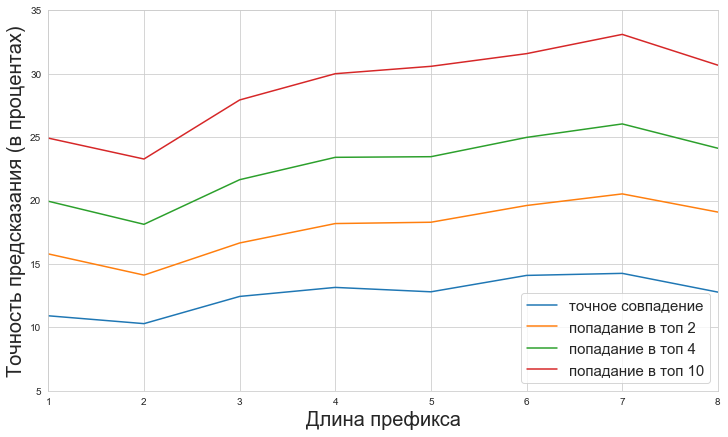

In [204]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
#plt.hist(lens_train, bins=len(np.unique(lens_train)))
bound = 8
grid = np.arange(0, bound, 1) + 1
plt.plot(grid, bigram_adv[1:bound+1] * 100, label="точное совпадение")

for n in [2, 4, 10]:
    plt.plot(grid, bigram_adv_top[1:bound+1, n-1] * 100, label="попадание в топ {}".format(n))

plt.xlim([1, bound])
plt.ylim([5, 35])
plt.xlabel("Длина префикса", fontsize=20)
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig('top_metric_with_statistic.png')

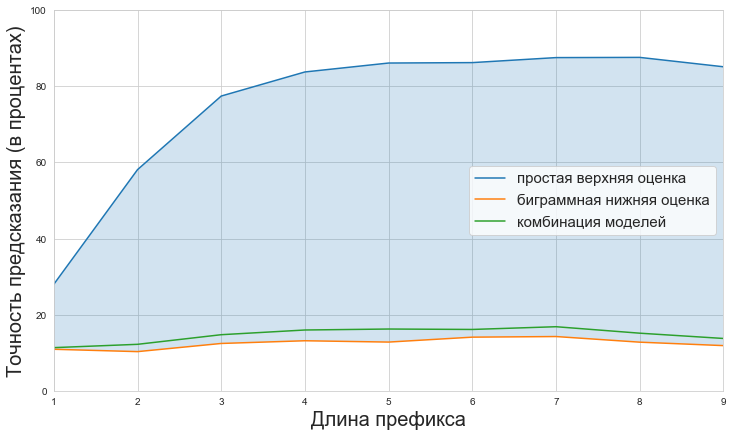

In [141]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
#plt.hist(lens_train, bins=len(np.unique(lens_train)))
bound = 10
grid = np.arange(0, bound, 1) + 1
plt.plot(grid, tmp_pad[1:bound+1] * 100, label='простая верхняя оценка')
plt.plot(grid, bigram_adv[1:bound+1] * 100, label="биграммная нижняя оценка")

plt.plot(grid, 100*np.array(on_test[:bound], dtype=float) * (1-test_pad[path]), 
         label="комбинация моделей")

plt.fill_between(grid, tmp_pad[1:bound+1] * 100, bigram_adv[1:bound+1] * 100, alpha=0.2)
plt.xlim([1, bound-1])
plt.ylim([0, 100])
plt.xlabel("Длина префикса", fontsize=20)
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig('upper_and_lower_with_final.png')

## Другая метрика успеха

In [171]:
def try_lengthes(data, n=1):
    accr = np.zeros((np.max(list(map(len, data[0]))), n))
    to_div = np.zeros((np.max(list(map(len, data[0]))), n))
    
    for _ in tqdm_notebook(range(0, len(data[0])-batch_size, batch_size)):
        batch = get_batch(data, _, _+batch_size, batch_size, word_to_ind)
        features, answers, bounds = compute_features(nets[0], batch)
        for i in range(1, len(nets)):
            feat, ans, b = compute_features(nets[i], batch)
            features = np.dstack([features, feat])
        
        accr_t, div_t = compute_accr(final, features, answers, bounds, n)
        accr[:len(accr_t), :] += accr_t
        to_div[:len(div_t), :] += div_t
    eps = 1
    return accr / (to_div + eps), accr.sum(axis=0) / to_div.sum(axis=0)

def compute_accr(network, batch, real_answers, bounds, n):
    batch = torch.tensor(batch, dtype=torch.float32)
    logits = network.forward(batch)
    logits = logits.view(-1, logits.shape[1])
    answers = torch.argsort(-logits, dim=-1).numpy()[:, :n]
    real_answers = real_answers.reshape(-1, 1)
    tmp = np.cumsum(np.array([answers == real_answers]) * np.array([answers != pad_id]), axis=-1)[0]
    accr = np.cumsum(tmp, axis=0)
    to_div = np.cumsum(np.array([real_answers != pad_id]))
    
    accuracy = np.zeros((len(bounds), n))
    to_divide = np.zeros_like(bounds)
    
    accuracy[0] = accr[bounds[0]-1]
    to_divide[0] = to_div[bounds[0]-1]
    for i in range(1, len(bounds)):
        accuracy[i] = accr[bounds[i]-1] - accr[bounds[i-1]-1]
        to_divide[i] = to_div[bounds[i]-1] - to_div[bounds[i-1]-1]
    
    return accuracy, to_divide.reshape(-1, 1)
    #return accuracy

In [172]:
possible_n = [1, 2, 4, 10]

accr, all_accr = try_lengthes(test_lem, 10)

In [173]:
accr[:bound, 0], on_test[:bound]

(array([0.14423841, 0.15532299, 0.18745746, 0.20316119, 0.20641078,
        0.20500835, 0.21413276, 0.19251825, 0.17488076, 0.10662824]),
 array([0.14423841, 0.15532299, 0.18745746, 0.20316119, 0.20641078,
        0.20500835, 0.21413276, 0.19251825, 0.17488076, 0.10662824]))

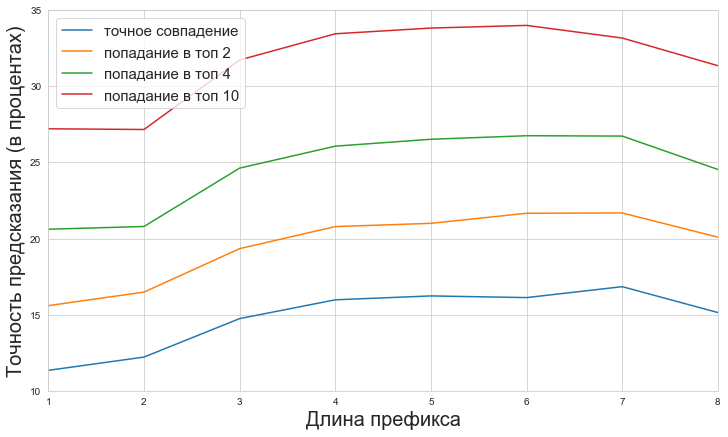

In [184]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1 
bound = len(grid)


plt.plot(grid, 100*np.array(on_test[:bound], dtype=float) * (1-test_pad[path]), 
         label="точное совпадение")
for n in possible_n[1:]:
    plt.plot(grid, 100*np.array(accr[:bound, n-1], dtype=float) * (1-test_pad[path]), 
             label="попадание в топ {}".format(n))



plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 8])
plt.ylim([10, 35])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("metric_top.png")

Построение графика сравнения attention моделей

In [112]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

In [113]:
train_st = dict()
test_st = dict()
train_pad = dict()
test_pad = dict()

for lm in ['']:
    
    count_words = Counter()

    for d in [train_lem[0]]:
        for q in d:
            for word in q:
                count_words[word] += 1
    
    
    num = '_2'
    path = 'emb' + num + lm + '_lemmatization.txt'
    f = open(path, 'r')
    count = 0
    i = -1
    tmp = []
    for line in f:
        if count==0:
            count = int(line.split()[0])
            i += 1
            if i == 5:
                train_st[path] = tmp
            tmp = []
        else:
            count -= 1
            y = float(line.split()[0])
            tmp.append(y)
    test_st[path] = tmp
        
        
    ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
        
        
    train_pad[path] = approximate_pad(train_lem[0])
    test_pad[path] = approximate_pad(test_lem[0])
                
    f.close()

In [115]:
path = 'emb_2_lemmatization.txt'
test_st[path][:10], test_pad[path]

([0.1357615894039735,
  0.1453094413491944,
  0.16995624696159456,
  0.1809510832538493,
  0.18803593303389138,
  0.19165275459098496,
  0.1905781584582441,
  0.18339416058394162,
  0.14149443561208266,
  0.0893371757925072],
 0.2135302679100857)

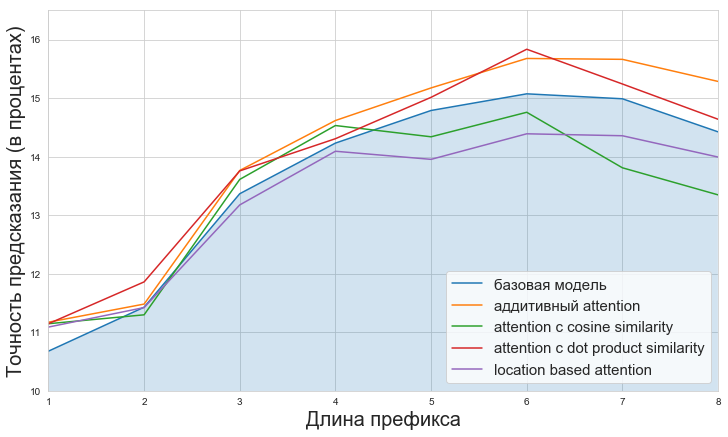

In [116]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

grid = np.arange(0, 8) + 1
bound = len(grid)

additive = [0.14205298, 0.14598705, 0.17501215, 0.18585638, 0.19293589, \
            0.19933222, 0.19914347, 0.19434307, 0.14467409, 0.10951009]
cosine = [0.14172185, 0.14365306, 0.17306757, 0.18476632, 0.18231931, \
        0.18764608, 0.17558887, 0.16970803, 0.14626391, 0.09510086]
dotprod = [0.14172185, 0.1508056 , 0.17491492, 0.18190489, 0.19089424, \
        0.20133556, 0.19379015, 0.18613139, 0.12877583, 0.10086455]
locbased = [0.14099338, 0.14523415, 0.16752552, 0.17917972, 0.17741935, \
        0.18297162, 0.18254818, 0.17791971, 0.14626391, 0.08933718]

path = 'emb_2_lemmatization.txt'
plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), 
         label="базовая модель")
plt.plot(grid, 100*np.array(additive[:bound], dtype=float) * (1-test_pad[path]), 
         label="аддитивный attention")
plt.plot(grid, 100*np.array(cosine[:bound], dtype=float) * (1-test_pad[path]), 
         label="attention c cosine similarity")
plt.plot(grid, 100*np.array(dotprod[:bound], dtype=float) * (1-test_pad[path]), 
         label="attention c dot product similarity")
plt.plot(grid, 100*np.array(locbased[:bound], dtype=float) * (1-test_pad[path]), 
         label="location based attention")
path = 'emb_2_lemmatization.txt'
plt.fill_between(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), alpha=0.2)

plt.xlabel("Длина префикса", fontsize=20)
plt.xlim([1, 8])
plt.ylim([10, 16.5])
plt.ylabel("Точность предсказания (в процентах)", fontsize=20)
#plt.title("Валидационный корпус", fontsize=20)
plt.legend(fontsize=15)
#plt.show()
plt.savefig("attention_.png")